In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip '/content/drive/MyDrive/Capstone/dataset.zip' -d '/content/drive/MyDrive/Capstone/Dataset'

Archive:  /content/drive/MyDrive/Capstone/dataset.zip
  inflating: /content/drive/MyDrive/Capstone/Dataset/classname.txt  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train.csv  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.1.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.10.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.100.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.101.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.102.jpg  
  inflating: /content/drive/MyDrive/Capstone/Dataset/train/angular_leaf_spot/angular_leaf_spot_train.103.jpg  
  inflating: /content/drive/MyDrive/Caps

In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras

In [9]:
TRAIN_DIR = "/content/drive/MyDrive/Capstone/Dataset/train"
VALIDATION_DIR = "/content/drive/MyDrive/Capstone/Dataset/val"

BATCH_SIZE = 32
IMAGE_SIZE =(224,224)
EPOCHS = 100

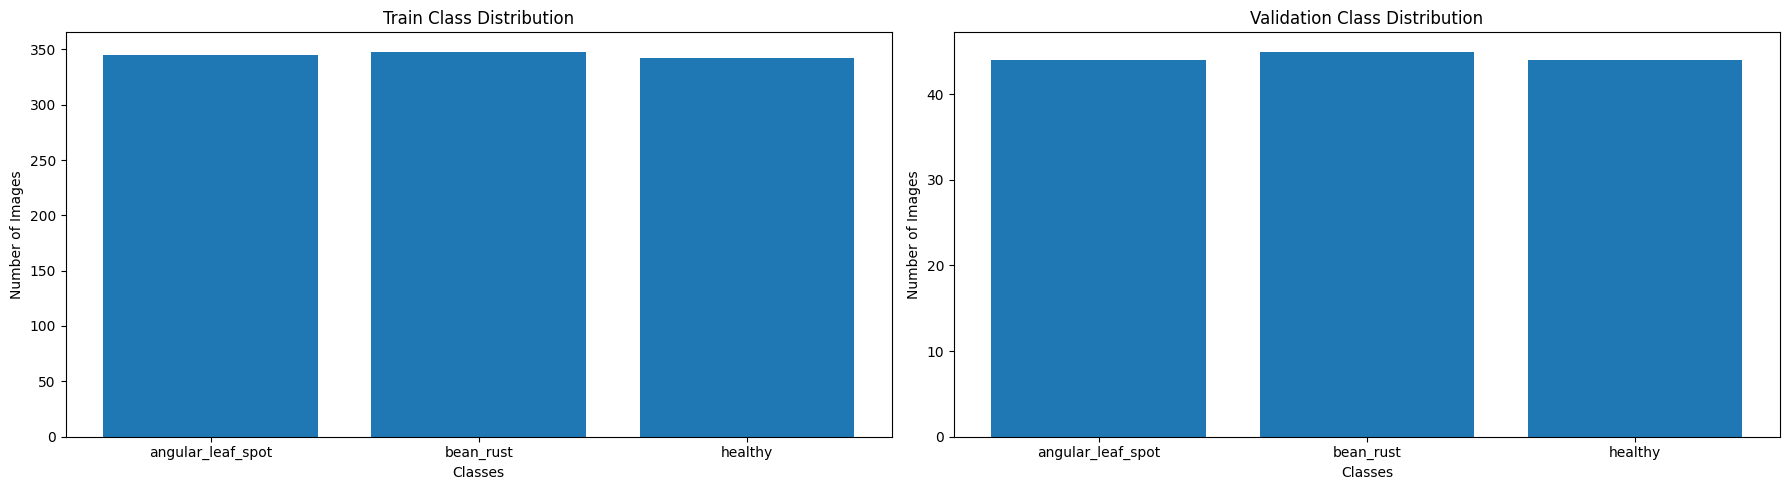

In [ ]:
import os
import matplotlib.pyplot as plt

# Paths to train, validation, and test directories
train_path = TRAIN_DIR
validation_path = VALIDATION_DIR

# Function to count the number of images in each class folder
def count_images_in_folders(path):
    class_counts = {}
    for class_folder in os.listdir(path):
        class_path = os.path.join(path, class_folder)
        if os.path.isdir(class_path):
            num_images = len(os.listdir(class_path))
            class_counts[class_folder] = num_images
    return class_counts

# Get class distributions for train, validation, and test sets
train_counts = count_images_in_folders(train_path)
validation_counts = count_images_in_folders(validation_path)

# Plotting the class distributions
fig, ax = plt.subplots(1, 2, figsize=(18, 5))

# Plot train class distribution
ax[0].bar(train_counts.keys(), train_counts.values())
ax[0].set_title('Train Class Distribution')
ax[0].set_xlabel('Classes')
ax[0].set_ylabel('Number of Images')

# Plot validation class distribution
ax[1].bar(validation_counts.keys(), validation_counts.values())
ax[1].set_title('Validation Class Distribution')
ax[1].set_xlabel('Classes')
ax[1].set_ylabel('Number of Images')

plt.tight_layout()
plt.show()


In [10]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=TRAIN_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    label_mode="categorical",
    color_mode = "rgb"
)

validation_dataset, test_dataset = tf.keras.utils.image_dataset_from_directory(
    directory=VALIDATION_DIR,
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical",
    color_mode = "rgb",
    validation_split=0.1,
    subset="both",
    seed=0
)

Found 1034 files belonging to 3 classes.
Found 133 files belonging to 3 classes.
Using 120 files for training.
Using 13 files for validation.


In [11]:
augmentation_layers = tf.keras.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.2)
])

In [12]:
train_dataset = train_dataset.map(lambda x, y: (augmentation_layers(x, training=True), y))

In [13]:
base_model = tf.keras.applications.VGG16(
    include_top=False,
    weights = "imagenet",
    input_shape=(224, 224, 3)
)

base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [14]:
model = tf.keras.models.Sequential([
    tf.keras.Input(shape=(224,224,3)),
    tf.keras.layers.Rescaling(1./255),
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=512,activation= "relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=512,activation= "relu"),
    tf.keras.layers.Dense(units=3,activation= "softmax"),
])


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics= ['accuracy', keras.metrics.Precision(name="precision"), keras.metrics.Recall(name="recall")]
)

In [15]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,241,539 (58.14 MB)

 Trainable params: 526,851 (2.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
earlyStopping = tf.keras.callbacks.EarlyStopping( monitor="val_loss", patience=10,
                                         verbose=1,  restore_best_weights=True)

In [17]:
model_history = model.fit(
	train_dataset,
	epochs=EPOCHS,
	validation_data=validation_dataset,
	callbacks = [earlyStopping]
)

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 160s 4s/step - accuracy: 0.3914 - loss: 1.1202 - precision: 0.4520 - recall: 0.2150 - val_accuracy: 0.6500 - val_loss: 0.8128 - val_precision: 0.8400 - val_recall: 0.3500
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 56s 389ms/step - accuracy: 0.5699 - loss: 0.8636 - precision: 0.6411 - recall: 0.4460 - val_accuracy: 0.7250 - val_loss: 0.6660 - val_precision: 0.7800 - val_recall: 0.6500
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 397ms/step - accuracy: 0.7196 - loss: 0.6737 - precision: 0.7500 - recall: 0.6503 - val_accuracy: 0.7250 - val_loss: 0.5974 - val_precision: 0.7619 - val_recall: 0.6667
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 13s 402ms/step - accuracy: 0.7136 - loss: 0.6739 - precision: 0.7440 - recall: 0.6634 - val_accuracy: 0.7833 - val_loss: 0.5620 - val_precision: 0.8108 - val_recall: 0.7500
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 411ms/step - accuracy: 0.7407 - loss: 0.6361 - precision: 0.7797 - recall: 0.7006 - val_accuracy: 0.7667 - val_


Val Accuracy: 0.8583333492279053
Val Precision: 0.8644067645072937
Val Recall: 0.8500000238418579


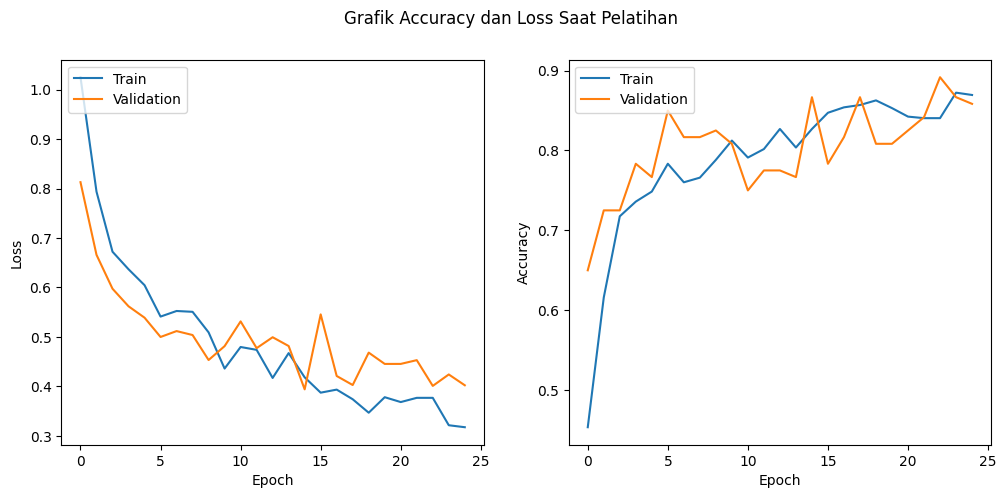

In [18]:
print("")
print(f"Val Accuracy: {(model_history.history['val_accuracy'])[-1]}")
print(f"Val Precision: {(model_history.history['val_precision'])[-1]}")
print(f"Val Recall: {(model_history.history['val_recall'])[-1]}")

plt.figure(figsize=(12, 5))
plt.suptitle('Grafik Accuracy dan Loss Saat Pelatihan')

plt.subplot(1, 2, 1)
plt.plot(model_history.history['loss'], label='loss')
plt.plot(model_history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(model_history.history['accuracy'], label='accuracy')
plt.plot(model_history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [19]:
scores = model.evaluate(test_dataset)
print(f"Accuracy: {scores[1]}")
print(f"Precision: {scores[2]}")
print(f"Recall: {scores[3]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step - accuracy: 0.8462 - loss: 0.4785 - precision: 0.8462 - recall: 0.8462
Accuracy: 0.8461538553237915
Precision: 0.8461538553237915
Recall: 0.8461538553237915


In [20]:
EXPORT_DIR = "/content/drive/MyDrive/Capstone/Models/22_Nov"
tf.saved_model.save(model, EXPORT_DIR)

In [2]:
!pip install tensorflowjs

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 103.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 116.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 113.4 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully u

In [21]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    --output_format=tfjs_graph_model \
    /content/drive/MyDrive/Capstone/Models/22_Nov\
    /content/drive/MyDrive/Capstone/JS_Models/22_Nov_TFJS

2024-11-22 13:31:59.886193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732282319.906277   10130 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732282319.913877   10130 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2024-11-22 13:32:03.012456: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1732282323.012625   10130 gpu_device.cc:2022] Created device /job:localhost/replica:0/task